# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

# Introduction

### Business problem

In this project we will try to find an optimal location that a family of three can move into, based on their preferences and requirements. Specifically, this report will be targeted to stakeholders interested in moving to Minneapolis, Minnesota.

Minneapolis is known as one of the most comfortable cities in the US. It is praised for its parks and theaters; it also reportedly has rather low crime rates. Most importantly, the Minneapolis-St.Paul metropolitan area is home to some 24 Fortune 1000 companies, and it is one of the country’s top economies. Some people even like to compare this city to New York.

In our case, a family of three is considering moving to Minneapolis since one of the parents was offered an interesting job opportunity there. They have never been to the state of Minnesota (and Minneapolis in particular), so they decided to consult a specialist on which neighborhood they should pick.

### Objective
The objective is to identify a neighborhood in Minneapolis that is most suitable for the given family. This analysis would be relevant and useful for other individuals planning to move to this city.

### Problem Statement
The family needs to find a neighborhood that will meet the following criteria:

1) be reasonably close to the earning parent’s workplace in Downtown East 
2) have a some grocery shops/farmers markets etc
3) have a selection of places to eat out 
4) have a green zone in the vicinity 
5) have low crime rates 
6) offer some form of entertainment and sports facilities (movies, gyms, etc.)

Data analysis will help to find the most suitalbe neighborhoods that the family will consider for relocation.

# Data 

We will begin our analysis by identifying the neighborhoods in Minneapolis using information from OpenData (http://opendata.minneapolismn.gov/datasets/minneapolis-neighborhoods/data). We will use geodata to visualize neighborhoods on the map to see which neighborhoods are closer to Downtown East.

We will then examine crime data in each neighborhood (also using data available at OpenData; the most recent information is for 2018: http://opendata.minneapolismn.gov/datasets/police-incidents-2018/data). We will identify the types of crimes that worry the family the most and then visualize the corresponding data on the map.

After this, data from Foursquare API will be used to determine the best neighborhoods in terms of infrastructure (shops, restaurants, parks, sports facilities, etc.)

Using a classification model (K-Means), neighborhoods will be grouped into clusters for comparison.

Finally, by comparing information about crime rates and level of infrastructure, a recommendation on the best 3-5 neighborhoods will be provided.

# Methodology

In this project we will direct our efforts on detecting neighborhoods of Minnesota that have low crime rates, particularly those with low number of crimes that involve individuals (as opposed to businesses/establishments), as well as neighborhoods that offer infrastructure that is appealing to the stakeholder (i.e. the family). The most suitable neighborhoods will have some green zones (parks, trails, playgrounds), grocery shops or farmers markets, as well as a sufficient number of cafes/restaurants.

In first step we will collect the required data:

- We we will gather data on crime rates for each neighborhood, cleaning all unnecessary data from the dataset;
- We will extract latitude and longitude values for each neighborhood (to use with foursquare API);
- Using foursquare API we will get location and type (category) of venues in each neighborhood of Minnesota.

Second step in our analysis will finding the most popular venues in each neighborhood and clustering the neighborhoods based on this information (using KMeans clustering).

In third and final step we will focus on most promising neighborhoods in each cluster and choose the most suitable neighborhoods by visualizing crime and venue data for the most promising neighborhoods (visualization will help to decide on the final neighborhood recommendations).

### First let's download all libraries that we might need

In [2]:
import pandas as pd
import numpy as np

#plotting libraries

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.ticker as ticker
%matplotlib inline

#modelling libraries

from sklearn import *
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import itertools

!pip install folium
import folium
import json
from pandas.io.json import json_normalize

import requests
from requests import get

!pip install geopy
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup

print("Libraries imported!")

     |████████████████████████████████| 102kB 6.4MB/s ta 0:00:011
Libraries imported!


In [3]:
#to show maps in github
from IPython.core.display import HTML

m = folium.Map(location=[ 44.97, -93.26])
HTML(m._repr_html_())

### Now we will import the crime data, which was previously loaded to our project storage as an asset

In [4]:
# The code was removed by Watson Studio for sharing.

FID            PublicAddress  ControlNbr             CCN  Precinct  \
0    1           0004XX 46 ST E     3743885  MP 2018 066210         3   
1    2           0010XX 8 ST SE     3744361  MP 2018 068876         2   
2    3          0008XX 13 AV SE     3744399  MP 2018 069260         2   
3    4     0002XX Hennepin AV S     3744486  MP 2018 066884         1   
4    5  0015XX New Brighton BL      3744556  MP 2018 069895         2   

          ReportedDate            BeginDate      Time Offense  \
0  2018/03/02 09:27:00  2018/03/02 03:37:59  03:38:00   BURGB   
1  2018/03/04 19:37:00  2018/03/03 23:00:00  23:00:00  AUTOTH   
2  2018/03/04 23:39:00  2018/03/04 02:00:00  02:00:00    TFMV   
3  2018/03/05 11:29:59  2018/03/02 18:11:00  18:11:00  SHOPLF   
4  2018/03/05 15:27:00  2018/03/05 14:23:59  14:24:00   THEFT   

            Description  UCRCode          EnteredDate    GBSID        Lat  \
0  Burglary Of Business        6  2018/03/02 09:12:42  12980.0  44.919705   
1   Motor Vehicle Theft        8  2018/03/04 19:36:52  17645.0  44.986351   
2  Theft From Motr Vehc        7  2018/03/04 23:39:10  16832.0  44.985314   
3           Shoplifting        7  2018/03/05 11:17:02  21314.0  44.982576   
4           Other Theft        7  2018/03/05 15:27:08  21511.0  45.003639   

        Long             X             Y    Neighborhood          LastChanged  \
0 -93.269608 -1.038273e+07  5.608889e+06          REGINA  2018/03/06 10:23:05   
1 -93.237514 -1.037915e+07  5.619373e+06    MARCY HOLMES  2018/03/06 05:16:34   
2 -93.233748 -1.037873e+07  5.619210e+06    MARCY HOLMES  2018/03/06 05:09:24   
3 -93.268417 -1.038259e+07  5.618779e+06      NORTH LOOP  2018/03/05 22:21:59   
4 -93.228834 -1.037819e+07  5.622094e+06  NORTHEAST PARK  2018/03/06 10:06:59   

        LastUpdateDate  
0  2018/03/06 20:00:34  
1  2018/03/06 20:00:34  
2  2018/03/06 20:00:34  
3  2018/03/06 20:00:34  
4  2018/03/06 20:00:34

### Let's check the unique types of crimes reported to decide which ones we will leave for analysis (not all will be relevant for our stakeholders)

In [5]:
crime_2018['Description'].unique()

array(['Burglary Of Business', 'Motor Vehicle Theft',
       'Theft From Motr Vehc', 'Shoplifting', 'Other Theft',
       'Burglary Of Dwelling', 'Theft From Person', 'Arson',
       'Crim Sex Cond-rape', 'Asslt W/dngrs Weapon',
       'Theft From Building', 'Robbery Per Agg',
       'Domestic Assault/Strangulation', 'Robbery Of Person',
       'Theft By Swindle', '2nd Deg Domes Aslt', 'Robbery Of Business',
       'Bike Theft', 'Aslt-sgnfcnt Bdly Hm', 'Theft-motr Veh Parts',
       'Aslt-great Bodily Hm', '3rd Deg Domes Aslt',
       'Aslt-police/emerg P', 'Murder (general)', 'Other Vehicle Theft',
       'Gas Station Driv-off', 'On-line Theft', 'Theft By Computer',
       'Disarm a Police Officer'], dtype=object)

<h3> We will look at 'Motor Vehicle Theft', 'Theft From Motr Vehc', 'Other Theft', 'Burglary of Dwelling', 'Theft From Person', 'Robbery of Person', 'Arson', 'Murder (general)', 'Crim Sex Cond-rape', 'Aslt-sgnfcnt Bdly Hm', 'Aslt-great Bodily Hm' and 'Asslt W/dngrs Weapon' as most relevant for a family.</h3>

In [6]:
#extract neighborhood names; first remove entries with no neighborhood name to eliminate 'nan' values
crime_2018.dropna(subset=['Neighborhood'], axis=0, inplace=True)
neighborhood_list = pd.DataFrame(crime_2018['Neighborhood'].unique())
header = ['Neighborhood']
neighborhood_list.columns = header
neighborhood_list.head()

Neighborhood
0            REGINA
1      MARCY HOLMES
2        NORTH LOOP
3    NORTHEAST PARK
4  ST. ANTHONY EAST

### Let's make a new dataframe with only the relevant data (neighborhood name, type of crime, and lat/lng values)

In [7]:
neighborhoods_crime = crime_2018[['Neighborhood','Description','Lat', 'Long']]
neighborhoods_crime = neighborhoods_crime.rename(columns={'Description':'Type of Crime', 'Lat':'Latitude', 'Long': 'Longitude'})
neighborhoods_crime.head()

Neighborhood         Type of Crime   Latitude  Longitude
0          REGINA  Burglary Of Business  44.919705 -93.269608
1    MARCY HOLMES   Motor Vehicle Theft  44.986351 -93.237514
2    MARCY HOLMES  Theft From Motr Vehc  44.985314 -93.233748
3      NORTH LOOP           Shoplifting  44.982576 -93.268417
4  NORTHEAST PARK           Other Theft  45.003639 -93.228834

<h3> Let's remove data on the types of crime that we are not interested in </h3>

In [8]:
neighborhoods_crime.drop(neighborhoods_crime.index[neighborhoods_crime['Type of Crime'] == 'Shoplifting'], inplace = True)
neighborhoods_crime.drop(neighborhoods_crime.index[neighborhoods_crime['Type of Crime'] == 'Burglary Of Business'], inplace = True)
neighborhoods_crime.drop(neighborhoods_crime.index[neighborhoods_crime['Type of Crime'] == 'Theft From Building'], inplace = True)
neighborhoods_crime.drop(neighborhoods_crime.index[neighborhoods_crime['Type of Crime'] == 'Robbery Per Agg'], inplace = True)
neighborhoods_crime.drop(neighborhoods_crime.index[neighborhoods_crime['Type of Crime'] == 'Domestic Assault/Strangulation'], inplace = True)
neighborhoods_crime.drop(neighborhoods_crime.index[neighborhoods_crime['Type of Crime'] == 'Theft By Swindle'], inplace = True)
neighborhoods_crime.drop(neighborhoods_crime.index[neighborhoods_crime['Type of Crime'] == '2nd Deg Domes Aslt'], inplace = True)
neighborhoods_crime.drop(neighborhoods_crime.index[neighborhoods_crime['Type of Crime'] == 'Robbery Of Business'], inplace = True)
neighborhoods_crime.drop(neighborhoods_crime.index[neighborhoods_crime['Type of Crime'] == 'Bike Theft'], inplace = True)
neighborhoods_crime.drop(neighborhoods_crime.index[neighborhoods_crime['Type of Crime'] == 'Theft-motr Veh Parts'], inplace = True)
neighborhoods_crime.drop(neighborhoods_crime.index[neighborhoods_crime['Type of Crime'] == '3rd Deg Domes Aslt'], inplace = True)
neighborhoods_crime.drop(neighborhoods_crime.index[neighborhoods_crime['Type of Crime'] == 'Aslt-police/emerg P'], inplace = True)
neighborhoods_crime.drop(neighborhoods_crime.index[neighborhoods_crime['Type of Crime'] == 'Other Vehicle Theft'], inplace = True)
neighborhoods_crime.drop(neighborhoods_crime.index[neighborhoods_crime['Type of Crime'] == 'Gas Station Driv-off'], inplace = True)
neighborhoods_crime.drop(neighborhoods_crime.index[neighborhoods_crime['Type of Crime'] == 'On-line Theft'], inplace = True)
neighborhoods_crime.drop(neighborhoods_crime.index[neighborhoods_crime['Type of Crime'] == 'Theft By Computer'], inplace = True)
neighborhoods_crime.drop(neighborhoods_crime.index[neighborhoods_crime['Type of Crime'] == 'Disarm a Police Officer'], inplace = True)

In [9]:
neighborhoods_crime['Type of Crime'].value_counts() #to check if we have only the relevant crimes left

Other Theft             2201
Theft From Motr Vehc    1082
Motor Vehicle Theft      865
Burglary Of Dwelling     797
Asslt W/dngrs Weapon     264
Robbery Of Person        154
Crim Sex Cond-rape       130
Theft From Person         86
Aslt-sgnfcnt Bdly Hm      66
Arson                     23
Murder (general)           9
Aslt-great Bodily Hm       7
Name: Type of Crime, dtype: int64

### let's see how many crimes are reported in each neighborhood in general

In [10]:
neighborhoods_crime['Neighborhood'].value_counts()

DOWNTOWN WEST                      568
WHITTIER                           202
MARCY HOLMES                       201
JORDAN                             173
LOWRY HILL EAST                    168
LORING PARK                        151
ELLIOT PARK                        141
WILLARD - HAY                      138
NEAR - NORTH                       135
LONGFELLOW                         125
NORTH LOOP                         122
HAWTHORNE                          122
SEWARD                             114
POWDERHORN PARK                    111
CARAG                              111
FOLWELL                            108
VENTURA VILLAGE                    107
LYNDALE                            104
CEDAR RIVERSIDE                    103
PROSPECT PARK - EAST RIVER ROAD     96
MIDTOWN PHILLIPS                    93
CENTRAL                             92
EAST ISLES                          84
EAST PHILLIPS                       81
COMO                                81
KING FIELD               

#### install geopandas to work with geojson data

In [11]:
!conda install --channel conda-forge geopandas

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    tbb-2018.0.5               |       h2d50403_0         1.1 MB  conda-forge
    click-plugins-1.1.1        |             py_0           9 KB  conda-forge
    cligj-0.5.0                |             py_0           8 KB  conda-forge
    tiledb-1.6.3               |       h1fb8f14_0         2.3 MB
    poppler-data-0.4.9         |                1         3.4 MB  conda-forge
    cfitsio-3.470              |       hb60a0a2_2         1.4 MB  conda-forge
    hdf4-4.2.13                |                0         969 KB  conda-forge
    poppler-0.65.0             |       h581218d_1         1.6 MB
    libspatialindex-1.9.3      |       he1b5a44_3         3.1 MB  conda-forge
    libgdal-3.0.2              |       

In [12]:
import geopandas as gpd

#### Now we can load the geojson file with neighborhood geometry

In [13]:
!wget --quiet https://opendata.arcgis.com/datasets/055ca54e5fcc47329f081c9ef51d038e_0.geojson  #geojson with neighborhood geometry data

In [14]:
fname = "https://opendata.arcgis.com/datasets/055ca54e5fcc47329f081c9ef51d038e_0.geojson"

df_neighb = gpd.read_file(fname)

print(type(df_neighb))

df_neighb

<class 'geopandas.geodataframe.GeoDataFrame'>


FID                            BDNAME BDNUM TEXT_NBR    Shape_STAr  \
0     1                     Phillips West    90       90  1.066925e+07   
1     2                     Downtown West    87       87  2.075613e+07   
2     3                     Downtown East    88       88  1.025499e+07   
3     4                   Ventura Village    89       89  1.263526e+07   
4     5                 Sumner - Glenwood    29       29  5.741860e+06   
5     6                     Shingle Creek     1       01  1.390042e+07   
6     7                    Lind - Bohanon     2       02  2.238271e+07   
7     8                   Webber - Camden     4       04  2.577256e+07   
8     9                         Bottineau    14       14  7.876321e+06   
9    10                           Victory     3       03  1.906496e+07   
10   11          Humboldt Industrial Area     8       08  7.640567e+06   
11   12                              Howe    63       63  2.964985e+07   
12   13                          Hiawatha    64       64  3.460429e+07   
13   14                            Windom    68       68  2.047533e+07   
14   15                          Ericsson    76       76  2.539773e+07   
15   16                             Field    77       77  9.638975e+06   
16   17                              Page    78       78  9.174383e+06   
17   18                              Como    37       37  3.144448e+07   
18   19                   Cedar Riverside    38       38  1.601156e+07   
19   20   Prospect Park - East River Road    39       39  3.553476e+07   
20   21           University of Minnesota    40       40  1.829534e+07   
21   22                            Jordan    24       24  2.220966e+07   
22   23                         Hawthorne    25       25  2.635671e+07   
23   24                     Willard - Hay    26       26  2.953789e+07   
24   25                      Near - North    27       27  2.959784e+07   
25   26                          Harrison    28       28  1.586976e+07   
26   27                       Loring Park    31       31  1.304429e+07   
27   28  Steven's Square - Loring Heights    32       32  5.182925e+06   
28   29                         Minnehaha    81       81  1.661354e+07   
29   30                      Diamond Lake    82       82  2.872947e+07   
..  ...                               ...   ...      ...           ...   
57   58                       Morris Park    84       84  1.504288e+07   
58   59             Mid - City Industrial    85       85  2.935043e+07   
59   60                  Midtown Phillips    91       91  1.033522e+07   
60   61                      West Calhoun    49       49  1.859301e+07   
61   62                       Bryn - Mawr    50       50  3.603828e+07   
62   63                    Northeast Park    20       20  2.040800e+07   
63   64                  St. Anthony West    21       21  1.363871e+07   
64   65                  St. Anthony East    22       22  5.628972e+06   
65   66                           Central    54       54  1.625896e+07   
66   67                   Powderhorn Park    55       55  2.042012e+07   
67   68                          Corcoran    56       56  1.271263e+07   
68   69                            Bryant    57       57  8.343380e+06   
69   70                             Kenny    67       67  1.791814e+07   
70   71                          Armatage    66       66  2.064531e+07   
71   72                          Beltrami    23       23  6.320790e+06   
72   73              Cedar - Isles - Dean    41       41  1.996141e+07   
73   74                           Kenwood    42       42  1.836155e+07   
74   75                        Lowry Hill    43       43  1.686386e+07   
75   76                        East Isles    44       44  9.485374e+06   
76   77                       Elliot Park    33       33  1.056287e+07   
77   78       Nicollet Island - East Bank    34       34  6.986586e+06   
78   79                      Marcy Holmes    35       35  2.332423e+07   
79   80 

#### As we can see, neighborhoods are not in all caps (as they are in our crime data), so we need to adjust them for consistency

In [15]:
df_neighb['BDNAME'] = df_neighb['BDNAME'].str.upper() 
df_neighb.drop(columns=['BDNUM','TEXT_NBR','NCR_LINK','IMAGE'],axis=1,inplace=True)

In [16]:
df_neighb.head()

FID             BDNAME    Shape_STAr    Shape_STLe  SHAPE_Length  \
0    1      PHILLIPS WEST  1.066925e+07  14403.885934      0.045801   
1    2      DOWNTOWN WEST  2.075613e+07  19220.602541      0.063671   
2    3      DOWNTOWN EAST  1.025499e+07  13436.601356      0.045179   
3    4    VENTURA VILLAGE  1.263526e+07  16988.532717      0.059590   
4    5  SUMNER - GLENWOOD  5.741860e+06  11065.343364      0.035535   

   SHAPE_Area                                           geometry  
0    0.000113  MULTIPOLYGON (((-93.26258 44.96091, -93.26258 ...  
1    0.000220  MULTIPOLYGON (((-93.26011 44.98300, -93.26010 ...  
2    0.000109  MULTIPOLYGON (((-93.24499 44.97893, -93.24499 ...  
3    0.000134  MULTIPOLYGON (((-93.24958 44.96630, -93.24951 ...  
4    0.000061  MULTIPOLYGON (((-93.28830 44.98904, -93.28830 ...

## Exploratory analysis

<h2> Let's look at the neighborhood borders on a map. </h2>

#### Firts we need to extract coordinates for Minneapolis itself

In [18]:
address = 'Minneapolis, MN'

geolocator = Nominatim(user_agent="mn_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograhpical coordinates of Minneapolis are {}, {}.'.format(latitude, longitude))

The geograhpical coordinates of Minneapolis are 44.9772995, -93.2654692.


#### Now we can create a map with neighborhood borders

In [19]:
# create map of Minneapolis using latitude and longitude values
map_minneapolis = folium.Map(location=[latitude, longitude], zoom_start=10)

#show neighborhoods on the map

folium.GeoJson(data = df_neighb, name='Neighborhoods', tooltip=folium.features.GeoJsonTooltip(fields=['BDNAME'], localize=True)).add_to(map_minneapolis)   
map_minneapolis

<h2> Let's visualize the crime data on a choropleth map </h2>

### First we need t o create a new dataframe with generalized crime data per neighborhood 

In [20]:
neigh_crime_counts = neighborhoods_crime['Neighborhood'].value_counts().to_frame()
crime_per_neighborhood = neigh_crime_counts.reset_index().rename(columns={'index': 'Neighborhood', 'Neighborhood':'Count'})
crime_per_neighborhood.head()

Neighborhood  Count
0    DOWNTOWN WEST    568
1         WHITTIER    202
2     MARCY HOLMES    201
3           JORDAN    173
4  LOWRY HILL EAST    168

#### Now we can proceed with the map

In [21]:
threshold_scale = np.linspace(crime_per_neighborhood['Count'].min(), crime_per_neighborhood['Count'].max(),6,dtype=int)
threshold_scale = threshold_scale.tolist()
threshold_scale[-1]=threshold_scale[-1]+1

In [22]:
latitude = 44.97
longitude = -93.26
mn_map = folium.Map(location=[latitude,longitude], zoom_start = 12)
mn_map.choropleth(
    geo_data = df_neighb,
    data = crime_per_neighborhood,
    key_on = 'feature.properties.BDNAME',
    fill_color = 'YlOrRd',
    fill_opacity = 0.8,
    line_opacity = 0.3,
    columns = ['Neighborhood', 'Count'],
    legend_name = 'Crime Rate in Minneapolis',
    reset = True
)

folium.GeoJson(data = df_neighb, name='Neighborhoods', tooltip=folium.features.GeoJsonTooltip(fields=['BDNAME'], localize=True)).add_to(mn_map)   


mn_map

/opt/conda/envs/Python36/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


<b>We can see only a couple of neighborhoods have significant crime levels, so we will not use crime data to limit our options so far. </b>

### Instead, we will prepare a dataframe that we will use to visualize crime levels in neighborhoods after we cluster them using fourquare api data

#### One-hot encoding

In [129]:
crime_onehot = pd.get_dummies(neighborhoods_crime[['Type of Crime']], prefix="", prefix_sep="")
crime_onehot['Neighborhood'] = neighborhoods_crime['Neighborhood']
fixed_cols = [crime_onehot.columns[-1]] + list(crime_onehot.columns[:-1])
crime_onehot = crime_onehot[fixed_cols]
crime_onehot.head()

Neighborhood  Arson  Aslt-great Bodily Hm  Aslt-sgnfcnt Bdly Hm  \
1      MARCY HOLMES      0                     0                     0   
2      MARCY HOLMES      0                     0                     0   
4    NORTHEAST PARK      0                     0                     0   
5  ST. ANTHONY EAST      0                     0                     0   
6       ELLIOT PARK      0                     0                     0   

   Asslt W/dngrs Weapon  Burglary Of Dwelling  Crim Sex Cond-rape  \
1                     0                     0                   0   
2                     0                     0                   0   
4                     0                     0                   0   
5                     0                     0                   0   
6                     0                     0                   0   

   Motor Vehicle Theft  Murder (general)  Other Theft  Robbery Of Person  \
1                    1                 0            0                  0   
2                    0                 0            0                  0   
4                    0                 0            1                  0   
5                    0                 0            0                  0   
6                    1                 0            0                  0   

   Theft From Motr Vehc  Theft From Person  
1                     0                  0  
2                     1                  0  
4                     0                  0  
5                     1                  0  
6                     0                  0

#### Group rows by neighborhood and by taking the mean of category occurence frequency


In [130]:
crime_grouped =crime_onehot.groupby('Neighborhood').mean().reset_index()
crime_grouped.head()

Neighborhood  Arson  Aslt-great Bodily Hm  Aslt-sgnfcnt Bdly Hm  \
0      ARMATAGE    0.0              0.000000                   0.0   
1  AUDUBON PARK    0.0              0.000000                   0.0   
2      BANCROFT    0.0              0.000000                   0.0   
3      BELTRAMI    0.0              0.000000                   0.0   
4     BOTTINEAU    0.0              0.043478                   0.0   

   Asslt W/dngrs Weapon  Burglary Of Dwelling  Crim Sex Cond-rape  \
0              0.000000              0.190476            0.000000   
1              0.000000              0.485714            0.028571   
2              0.000000              0.333333            0.000000   
3              0.076923              0.076923            0.000000   
4              0.043478              0.173913            0.000000   

   Motor Vehicle Theft  Murder (general)  Other Theft  Robbery Of Person  \
0             0.000000               0.0     0.190476           0.000000   
1             0.100000               0.0     0.242857           0.000000   
2             0.190476               0.0     0.238095           0.000000   
3             0.000000               0.0     0.230769           0.000000   
4             0.217391               0.0     0.173913           0.043478   

   Theft From Motr Vehc  Theft From Person  
0              0.619048           0.000000  
1              0.128571           0.014286  
2              0.238095           0.000000  
3              0.615385           0.000000  
4              0.260870           0.043478

#### Set neighborhood as index

In [131]:
crime_grouped.set_index('Neighborhood', inplace=True)

## Now we will get ready to use Foursquare API

<h3> First let's extract lat/lon values for the neighborhoods to look at them in Foursquare</h3>

### Since we have multipolygons, we can extract centroids for each neighborhood

In [23]:
centroids = pd.DataFrame(df_neighb['geometry'].centroid)
header = ['Centroid']
centroids.columns = header
centroids.head()

Centroid
0  POINT (-93.26734 44.95386)
1  POINT (-93.27012 44.97784)
2  POINT (-93.25411 44.97606)
3  POINT (-93.25790 44.96278)
4  POINT (-93.29160 44.98403)

### Now we can add the column with centroids to our neighborhood dataframe

In [24]:
neighb_w_centroids = df_neighb.join(centroids, sort = False)
neighb_w_centroids.head()

FID             BDNAME    Shape_STAr    Shape_STLe  SHAPE_Length  \
0    1      PHILLIPS WEST  1.066925e+07  14403.885934      0.045801   
1    2      DOWNTOWN WEST  2.075613e+07  19220.602541      0.063671   
2    3      DOWNTOWN EAST  1.025499e+07  13436.601356      0.045179   
3    4    VENTURA VILLAGE  1.263526e+07  16988.532717      0.059590   
4    5  SUMNER - GLENWOOD  5.741860e+06  11065.343364      0.035535   

   SHAPE_Area                                           geometry  \
0    0.000113  MULTIPOLYGON (((-93.26258 44.96091, -93.26258 ...   
1    0.000220  MULTIPOLYGON (((-93.26011 44.98300, -93.26010 ...   
2    0.000109  MULTIPOLYGON (((-93.24499 44.97893, -93.24499 ...   
3    0.000134  MULTIPOLYGON (((-93.24958 44.96630, -93.24951 ...   
4    0.000061  MULTIPOLYGON (((-93.28830 44.98904, -93.28830 ...   

                     Centroid  
0  POINT (-93.26734 44.95386)  
1  POINT (-93.27012 44.97784)  
2  POINT (-93.25411 44.97606)  
3  POINT (-93.25790 44.96278)  
4  POINT (-93.29160 44.98403)

### However, we still do not have separate values for latitude and longitude; let's extract those from the centroid Points

In [29]:
from shapely.geometry import Point

#### We create a new dataframe with lat/lng values that we will add to the neighborhoods dataframe

In [45]:
column_names = ['Latitude', 'Longitude']
lat_lng = pd.DataFrame(columns=column_names)
lat_lng 

Empty DataFrame
Columns: [Latitude, Longitude]
Index: []

#### Now we insert it to the main dataframe

In [48]:
neighb_latlng = neighb_w_centroids.join(lat_lng, sort = False)
neighb_latlng.head()

FID             BDNAME    Shape_STAr    Shape_STLe  SHAPE_Length  \
0    1      PHILLIPS WEST  1.066925e+07  14403.885934      0.045801   
1    2      DOWNTOWN WEST  2.075613e+07  19220.602541      0.063671   
2    3      DOWNTOWN EAST  1.025499e+07  13436.601356      0.045179   
3    4    VENTURA VILLAGE  1.263526e+07  16988.532717      0.059590   
4    5  SUMNER - GLENWOOD  5.741860e+06  11065.343364      0.035535   

   SHAPE_Area                                           geometry  \
0    0.000113  MULTIPOLYGON (((-93.26258 44.96091, -93.26258 ...   
1    0.000220  MULTIPOLYGON (((-93.26011 44.98300, -93.26010 ...   
2    0.000109  MULTIPOLYGON (((-93.24499 44.97893, -93.24499 ...   
3    0.000134  MULTIPOLYGON (((-93.24958 44.96630, -93.24951 ...   
4    0.000061  MULTIPOLYGON (((-93.28830 44.98904, -93.28830 ...   

                     Centroid Latitude Longitude  
0  POINT (-93.26734 44.95386)      NaN       NaN  
1  POINT (-93.27012 44.97784)      NaN       NaN  
2  POINT (-93.25411 44.97606)      NaN       NaN  
3  POINT (-93.25790 44.96278)      NaN       NaN  
4  POINT (-93.29160 44.98403)      NaN       NaN

### Now we can populate the empty latitude and longitude columns with data from the centroid column

In [72]:
for i, row in enumerate(neighb_latlng.values):
    neighb_latlng['Latitude'][i] = neighb_latlng['Centroid'][i].y 
    neighb_latlng['Longitude'][i] = neighb_latlng['Centroid'][i].x
    #looping through centroids to extract latitude and longitude

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [73]:
neighb_latlng.head() #check the results

FID             BDNAME    Shape_STAr    Shape_STLe  SHAPE_Length  \
0    1      PHILLIPS WEST  1.066925e+07  14403.885934      0.045801   
1    2      DOWNTOWN WEST  2.075613e+07  19220.602541      0.063671   
2    3      DOWNTOWN EAST  1.025499e+07  13436.601356      0.045179   
3    4    VENTURA VILLAGE  1.263526e+07  16988.532717      0.059590   
4    5  SUMNER - GLENWOOD  5.741860e+06  11065.343364      0.035535   

   SHAPE_Area                                           geometry  \
0    0.000113  MULTIPOLYGON (((-93.26258 44.96091, -93.26258 ...   
1    0.000220  MULTIPOLYGON (((-93.26011 44.98300, -93.26010 ...   
2    0.000109  MULTIPOLYGON (((-93.24499 44.97893, -93.24499 ...   
3    0.000134  MULTIPOLYGON (((-93.24958 44.96630, -93.24951 ...   
4    0.000061  MULTIPOLYGON (((-93.28830 44.98904, -93.28830 ...   

                     Centroid Latitude Longitude  
0  POINT (-93.26734 44.95386)  44.9539  -93.2673  
1  POINT (-93.27012 44.97784)  44.9778  -93.2701  
2  POINT (-93.25411 44.97606)  44.9761  -93.2541  
3  POINT (-93.25790 44.96278)  44.9628  -93.2579  
4  POINT (-93.29160 44.98403)   44.984  -93.2916

### Let's create a new dataframe with only the neighborhood names and corresponding lat/lng values, which will be used for working with Foursquare

In [74]:
neighborhood_ll = neighb_latlng[['BDNAME','Latitude','Longitude']]
neighborhood_ll.rename(columns={'BDNAME':'Neighborhood'}, inplace=True)
neighborhood_ll.head() 

Neighborhood Latitude Longitude
0      PHILLIPS WEST  44.9539  -93.2673
1      DOWNTOWN WEST  44.9778  -93.2701
2      DOWNTOWN EAST  44.9761  -93.2541
3    VENTURA VILLAGE  44.9628  -93.2579
4  SUMNER - GLENWOOD   44.984  -93.2916

### Declare our Foursquare credentials

In [55]:
# @hidden cell
CLIENT_ID = 'QU0AGC3JGTUWXHRWGSAEIQDV2IAJ5FNNCCA1EPIANRTSLTRG' #foursquare id
CLIENT_SECRET = 'KBU5XEABG33PJGFEGTTGWTFN01G2NBCAXZQA1SEMIKZFA3EG' #foursquare secret
VERSION = '20180605' #foursquare api version

### Let's explore the first neighborhood

In [75]:
neighborhood_ll.loc[0, 'Neighborhood'] 

'PHILLIPS WEST'

### Find out its latitude and longitude and send a corresponding get request to foursquare api

In [76]:
neigh_lat = neighborhood_ll.loc[0, 'Latitude']
neigh_lng = neighborhood_ll.loc[0, 'Longitude']
neigh_name = neighborhood_ll.loc[0, 'Neighborhood']

print('Latitude and longitude of {} are {}, {}.'.format(neigh_name, neigh_lat, neigh_lng))

Latitude and longitude of PHILLIPS WEST are 44.95386251041105, -93.26734303161291.


In [77]:
#explore our first neighborhood on Foursquare
LIMIT = 30 #how many venues we want to see
radius = 1000
#creating the URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    neigh_lat, 
    neigh_lng, 
    radius,
    LIMIT)
# url #to check the url

'https://api.foursquare.com/v2/venues/explore?&client_id=QU0AGC3JGTUWXHRWGSAEIQDV2IAJ5FNNCCA1EPIANRTSLTRG&client_secret=KBU5XEABG33PJGFEGTTGWTFN01G2NBCAXZQA1SEMIKZFA3EG&v=20180605&ll=44.95386251041105,-93.26734303161291&radius=1000&limit=30'

In [ ]:
# @hidden cell
url

### Our results for the first neighborhood

In [78]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ec3a4ca542890001b627f6d'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Phillips',
  'headerFullLocation': 'Phillips, Minneapolis',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 104,
  'suggestedBounds': {'ne': {'lat': 44.96286251941106,
    'lng': -93.25464907903691},
   'sw': {'lat': 44.94486250141104, 'lng': -93.28003698418891}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '49c3cce6f964a5207a561fe3',
       'name': 'American Swedish Institute',
       'location': {'address': '2600 Park Ave',
        'crossStreet': 'E 26th St',
        'lat': 44.95464142104341,
        'lng': -9

### Define a function to get the category of a venue

In [79]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Clean our json and put it into a pandas dataframe for future use

In [80]:
venues = results['response']['groups'][0]['items']

local_venues = json_normalize(venues)
#filer out the columns we will need
filtered_cols = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
local_venues = local_venues.loc[:, filtered_cols]
#filter venue categories
local_venues['venue.categories'] = local_venues.apply(get_category_type, axis=1)

local_venues.columns = [col.split(".")[-1] for col in local_venues.columns]

local_venues.head()

name               categories        lat        lng
0    American Swedish Institute                   Museum  44.954641 -93.265787
1                          FIKA  Scandinavian Restaurant  44.954555 -93.265717
2  Minneapolis Institute of Art               Art Museum  44.958554 -93.273284
3          Taqueria La Hacienda       Mexican Restaurant  44.948605 -93.271181
4    Children's Theatre Company                  Theater  44.957949 -93.273466

In [174]:
local_venues['categories'].unique()  #check unique venues in the neighborhood

array(['Museum', 'Scandinavian Restaurant', 'Art Museum',
       'Mexican Restaurant', 'Theater', 'Food Court',
       'Vietnamese Restaurant', 'Bakery', 'Performing Arts Venue',
       'Donut Shop', 'Bar', 'Greek Restaurant', 'Pizza Place',
       'Dessert Shop', 'American Restaurant', 'Caribbean Restaurant',
       'Gym', 'Martial Arts Dojo', 'Taco Place', 'Record Shop', 'Brewery',
       'Sandwich Place', 'College Arts Building', 'Ramen Restaurant'],
      dtype=object)

## Now we can explore all neighborhoods

### First define a function to list popular local venue in all neighborhoods

In [82]:
def getLocalVenues(names, latitudes, longitudes, radius = 1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    local_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    local_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(local_venues) 

In [83]:
minneapolis_venues = getLocalVenues(names = neighborhood_ll['Neighborhood'],
                               latitudes = neighborhood_ll['Latitude'],
                               longitudes = neighborhood_ll['Longitude'])

PHILLIPS WEST
DOWNTOWN WEST
DOWNTOWN EAST
VENTURA VILLAGE
SUMNER - GLENWOOD
SHINGLE CREEK
LIND - BOHANON
WEBBER - CAMDEN
BOTTINEAU
VICTORY
HUMBOLDT INDUSTRIAL AREA
HOWE
HIAWATHA
WINDOM
ERICSSON
FIELD
PAGE
COMO
CEDAR RIVERSIDE
PROSPECT PARK - EAST RIVER ROAD
UNIVERSITY OF MINNESOTA
JORDAN
HAWTHORNE
WILLARD - HAY
NEAR - NORTH
HARRISON
LORING PARK
STEVEN'S SQUARE - LORING HEIGHTS
MINNEHAHA
DIAMOND LAKE
COOPER
TANGLETOWN
NORTH LOOP
HALE
KEEWAYDIN
FULTON
LYNNHURST
BANCROFT
STANDISH
SEWARD
LONGFELLOW
LOWRY HILL EAST
ECCO
SOUTH UPTOWN
EAST PHILLIPS
CLEVELAND
WENONAH
HOLLAND
AUDUBON PARK
REGINA
NORTHROP
SHERIDAN
LOGAN PARK
WINDOM PARK
LINDEN HILLS
EAST HARRIET
KING FIELD
MORRIS PARK
MID - CITY INDUSTRIAL
MIDTOWN PHILLIPS
WEST CALHOUN
BRYN - MAWR
NORTHEAST PARK
ST. ANTHONY WEST
ST. ANTHONY EAST
CENTRAL
POWDERHORN PARK
CORCORAN
BRYANT
KENNY
ARMATAGE
BELTRAMI
CEDAR - ISLES - DEAN
KENWOOD
LOWRY HILL
EAST ISLES
ELLIOT PARK
NICOLLET ISLAND - EAST BANK
MARCY HOLMES
FOLWELL
MCKINLEY
CAMDEN INDUSTRIAL


### Let's preview our dataframe

In [84]:
minneapolis_venues.head() 

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  PHILLIPS WEST              44.953863              -93.267343   
1  PHILLIPS WEST              44.953863              -93.267343   
2  PHILLIPS WEST              44.953863              -93.267343   
3  PHILLIPS WEST              44.953863              -93.267343   
4  PHILLIPS WEST              44.953863              -93.267343   

                          Venue  Venue Latitude  Venue Longitude  \
0    American Swedish Institute       44.954641       -93.265787   
1                          FIKA       44.954555       -93.265717   
2  Minneapolis Institute of Art       44.958554       -93.273284   
3          Taqueria La Hacienda       44.948605       -93.271181   
4    Children's Theatre Company       44.957949       -93.273466   

            Venue Category  
0                   Museum  
1  Scandinavian Restaurant  
2               Art Museum  
3       Mexican Restaurant  
4                  Theater

### Check how many unique venue categories we have 

In [86]:
print('There are {} uniques categories.'.format(len(minneapolis_venues['Venue Category'].unique())))

There are 253 uniques categories.


### Now we need to group our venues according to neighborhood

#### One-hot encoding

In [87]:
minneapolis_onehot = pd.get_dummies(minneapolis_venues[['Venue Category']], prefix="", prefix_sep="")
minneapolis_onehot['Neighborhood'] = minneapolis_venues['Neighborhood']
fixed_cols = [minneapolis_onehot.columns[-1]] + list(minneapolis_onehot.columns[:-1])
minneapolis_onehot = minneapolis_onehot[fixed_cols]
minneapolis_onehot.head()

Neighborhood  ATM  Accessories Store  Acupuncturist  Adult Boutique  \
0  PHILLIPS WEST    0                  0              0               0   
1  PHILLIPS WEST    0                  0              0               0   
2  PHILLIPS WEST    0                  0              0               0   
3  PHILLIPS WEST    0                  0              0               0   
4  PHILLIPS WEST    0                  0              0               0   

   Advertising Agency  African Restaurant  American Restaurant  Antique Shop  \
0                   0                   0                    0             0   
1                   0                   0                    0             0   
2                   0                   0                    0             0   
3                   0                   0                    0             0   
4                   0                   0                    0             0   

   Arcade  ...  Vegetarian / Vegan Restaurant  Video Store  \
0       0  ...                              0            0   
1       0  ...                              0            0   
2       0  ...                              0            0   
3       0  ...                              0            0   
4       0  ...                              0            0   

   Vietnamese Restaurant  Warehouse Store  Waterfall  Wine Bar  Wine Shop  \
0                      0                0          0         0          0   
1                      0                0          0         0          0   
2                      0                0          0         0          0   
3                      0                0          0         0          0   
4                      0                0          0         0          0   

   Winery  Women's Store  Yoga Studio  
0       0              0            0  
1       0              0            0  
2       0              0            0  
3       0              0            0  
4       0              0            0  

[5 rows x 254 columns]

### Group rows by neighborhood and by taking the mean of category occurence frequency

In [88]:
minneapolis_grouped = minneapolis_onehot.groupby('Neighborhood').mean().reset_index()
minneapolis_grouped.head()

Neighborhood  ATM  Accessories Store  Acupuncturist  Adult Boutique  \
0      ARMATAGE  0.0           0.000000            0.0             0.0   
1  AUDUBON PARK  0.0           0.000000            0.0             0.0   
2      BANCROFT  0.0           0.033333            0.0             0.0   
3      BELTRAMI  0.0           0.000000            0.0             0.0   
4     BOTTINEAU  0.0           0.000000            0.0             0.0   

   Advertising Agency  African Restaurant  American Restaurant  Antique Shop  \
0                 0.0                 0.0             0.000000           0.0   
1                 0.0                 0.0             0.033333           0.0   
2                 0.0                 0.0             0.033333           0.0   
3                 0.0                 0.0             0.033333           0.0   
4                 0.0                 0.0             0.066667           0.0   

   Arcade  ...  Vegetarian / Vegan Restaurant  Video Store  \
0     0.0  ...                            0.0     0.043478   
1     0.0  ...                            0.0     0.033333   
2     0.0  ...                            0.0     0.033333   
3     0.0  ...                            0.0     0.000000   
4     0.0  ...                            0.0     0.000000   

   Vietnamese Restaurant  Warehouse Store  Waterfall  Wine Bar  Wine Shop  \
0               0.000000              0.0        0.0       0.0        0.0   
1               0.033333              0.0        0.0       0.0        0.0   
2               0.000000              0.0        0.0       0.0        0.0   
3               0.033333              0.0        0.0       0.0        0.0   
4               0.033333              0.0        0.0       0.0        0.0   

   Winery  Women's Store  Yoga Studio  
0     0.0            0.0     0.000000  
1     0.0            0.0     0.000000  
2     0.0            0.0     0.000000  
3     0.0            0.0     0.033333  
4     0.0            0.0     0.000000  

[5 rows x 254 columns]

### Let's print each neighborhood with top 5 common venues

In [89]:
num_top_venues = 5

for hood in minneapolis_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = minneapolis_grouped[minneapolis_grouped['Neighborhood']==hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ARMATAGE----
                 venue  freq
0          Pizza Place  0.13
1                Trail  0.09
2  Arts & Crafts Store  0.04
3   Mexican Restaurant  0.04
4                  Gym  0.04


----AUDUBON PARK----
             venue  freq
0             Park  0.10
1           Bakery  0.10
2  Thai Restaurant  0.07
3          Brewery  0.07
4      Coffee Shop  0.07


----BANCROFT----
               venue  freq
0               Park  0.13
1        Coffee Shop  0.07
2  Food & Drink Shop  0.07
3         Restaurant  0.03
4          BBQ Joint  0.03


----BELTRAMI----
         venue  freq
0      Brewery  0.13
1    BBQ Joint  0.07
2     Dive Bar  0.07
3  Coffee Shop  0.07
4  Yoga Studio  0.03


----BOTTINEAU----
                 venue  freq
0             Dive Bar  0.13
1       Ice Cream Shop  0.07
2          Coffee Shop  0.07
3  American Restaurant  0.07
4                 Café  0.07


----BRYANT----
                 venue  freq
0                 Park  0.13
1  American Restaurant  0.10
2          C

### Now we can put this data into a dataframe

#### frist write a function to sort venues in descending order

In [90]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### create a df and display top 10 venues for each neighborhood

In [91]:
#import numpy as np if not yet imported

num_top_venues = 10 

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#new df
neighborhoods_venues_sorted = pd.DataFrame(columns = columns)
neighborhoods_venues_sorted['Neighborhood'] = minneapolis_grouped['Neighborhood']

for ind in np.arange(minneapolis_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(minneapolis_grouped.iloc[ind, : ], num_top_venues)
    
neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0      ARMATAGE           Pizza Place                 Trail   
1  AUDUBON PARK                  Park                Bakery   
2      BANCROFT                  Park     Food & Drink Shop   
3      BELTRAMI               Brewery             BBQ Joint   
4     BOTTINEAU              Dive Bar           Coffee Shop   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0            Restaurant   Arts & Crafts Store           Flower Shop   
1              Pharmacy               Brewery           Pizza Place   
2           Coffee Shop              Pharmacy             BBQ Joint   
3              Dive Bar           Coffee Shop           Yoga Studio   
4      Theme Restaurant        Ice Cream Shop   American Restaurant   

  6th Most Common Venue 7th Most Common Venue      8th Most Common Venue  \
0    Mexican Restaurant             Pet Store          French Restaurant   
1           Coffee Shop       Thai Restaurant                  Hotel Bar   
2    Mexican Restaurant            Food Truck  South American Restaurant   
3                  Park        Cosmetics Shop                 Donut Shop   
4                  Café             Pet Store                  Bookstore   

  9th Most Common Venue   10th Most Common Venue  
0           Supermarket       Chinese Restaurant  
1       Organic Grocery             Liquor Store  
2    Chinese Restaurant   Furniture / Home Store  
3           Event Space                     Café  
4             Speakeasy  New American Restaurant

<h2> Now let's cluster our neighborhoods using KMeans </h2>

In [92]:
# set number of clusters
kclusters = 6

minneapolis_grouped_clustering = minneapolis_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(minneapolis_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 2, 4, 4, 2, 1, 2, 1, 4], dtype=int32)

In [100]:
minneapolis_grouped_clustering.head()

ATM  Accessories Store  Acupuncturist  Adult Boutique  Advertising Agency  \
0  0.0           0.000000            0.0             0.0                 0.0   
1  0.0           0.000000            0.0             0.0                 0.0   
2  0.0           0.033333            0.0             0.0                 0.0   
3  0.0           0.000000            0.0             0.0                 0.0   
4  0.0           0.000000            0.0             0.0                 0.0   

   African Restaurant  American Restaurant  Antique Shop  Arcade  \
0                 0.0             0.000000           0.0     0.0   
1                 0.0             0.033333           0.0     0.0   
2                 0.0             0.033333           0.0     0.0   
3                 0.0             0.033333           0.0     0.0   
4                 0.0             0.066667           0.0     0.0   

   Arepa Restaurant  ...  Vegetarian / Vegan Restaurant  Video Store  \
0               0.0  ...                            0.0     0.043478   
1               0.0  ...                            0.0     0.033333   
2               0.0  ...                            0.0     0.033333   
3               0.0  ...                            0.0     0.000000   
4               0.0  ...                            0.0     0.000000   

   Vietnamese Restaurant  Warehouse Store  Waterfall  Wine Bar  Wine Shop  \
0               0.000000              0.0        0.0       0.0        0.0   
1               0.033333              0.0        0.0       0.0        0.0   
2               0.000000              0.0        0.0       0.0        0.0   
3               0.033333              0.0        0.0       0.0        0.0   
4               0.033333              0.0        0.0       0.0        0.0   

   Winery  Women's Store  Yoga Studio  
0     0.0            0.0     0.000000  
1     0.0            0.0     0.000000  
2     0.0            0.0     0.000000  
3     0.0            0.0     0.033333  
4     0.0            0.0     0.000000  

[5 rows x 253 columns]

### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [101]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
minneapolis_merged = neighborhood_ll

# merge to add latitude/longitude for each neighborhood
minneapolis_merged = minneapolis_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

minneapolis_merged.head() 

Neighborhood Latitude Longitude  Cluster Labels 1st Most Common Venue  \
0      PHILLIPS WEST  44.9539  -93.2673               3    Mexican Restaurant   
1      DOWNTOWN WEST  44.9778  -93.2701               4               Theater   
2      DOWNTOWN EAST  44.9761  -93.2541               4                   Bar   
3    VENTURA VILLAGE  44.9628  -93.2579               2           Coffee Shop   
4  SUMNER - GLENWOOD   44.984  -93.2916               4               Brewery   

    2nd Most Common Venue    3rd Most Common Venue  4th Most Common Venue  \
0   Vietnamese Restaurant      American Restaurant  Performing Arts Venue   
1      Italian Restaurant  New American Restaurant            Music Venue   
2                   Hotel                     Park    Japanese Restaurant   
3                    Park            Grocery Store               Pharmacy   
4  Thrift / Vintage Store           Farmers Market             Food Truck   

  5th Most Common Venue 6th Most Common Venue    7th Most Common Venue  \
0               Theater        Sandwich Place  Scandinavian Restaurant   
1      Baseball Stadium            Restaurant                      Bar   
2           Yoga Studio        Scenic Lookout               Public Art   
3               Theater                  Café              Flower Shop   
4         Deli / Bodega      Business Service                     Café   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0                   Bar            Taco Place  College Arts Building  
1      Sushi Restaurant      Pedestrian Plaza             Donut Shop  
2            Non-Profit           Music Venue           Music School  
3                Bridge         Shopping Mall         Breakfast Spot  
4           Fish Market                   Bar         Clothing Store

## Now we can visualize our clusters on a map of Minneapolis

In [102]:
# create map
latitude = location.latitude
longitude = location.longitude
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(minneapolis_merged['Latitude'], minneapolis_merged['Longitude'], minneapolis_merged['Neighborhood'], minneapolis_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Let's create a new dataframe that we'll use to visualize most popular venues in chosen neighborhoods

In [268]:
mn_venues = minneapolis_grouped.set_index('Neighborhood')
mn_venues.head()

ATM  Accessories Store  Acupuncturist  Adult Boutique  \
Neighborhood                                                          
ARMATAGE      0.0           0.000000            0.0             0.0   
AUDUBON PARK  0.0           0.000000            0.0             0.0   
BANCROFT      0.0           0.033333            0.0             0.0   
BELTRAMI      0.0           0.000000            0.0             0.0   
BOTTINEAU     0.0           0.000000            0.0             0.0   

              Advertising Agency  African Restaurant  American Restaurant  \
Neighborhood                                                                
ARMATAGE                     0.0                 0.0             0.000000   
AUDUBON PARK                 0.0                 0.0             0.033333   
BANCROFT                     0.0                 0.0             0.033333   
BELTRAMI                     0.0                 0.0             0.033333   
BOTTINEAU                    0.0                 0.0             0.066667   

              Antique Shop  Arcade  Arepa Restaurant  ...  \
Neighborhood                                          ...   
ARMATAGE               0.0     0.0               0.0  ...   
AUDUBON PARK           0.0     0.0               0.0  ...   
BANCROFT               0.0     0.0               0.0  ...   
BELTRAMI               0.0     0.0               0.0  ...   
BOTTINEAU              0.0     0.0               0.0  ...   

              Vegetarian / Vegan Restaurant  Video Store  \
Neighborhood                                               
ARMATAGE                                0.0     0.043478   
AUDUBON PARK                            0.0     0.033333   
BANCROFT                                0.0     0.033333   
BELTRAMI                                0.0     0.000000   
BOTTINEAU                               0.0     0.000000   

              Vietnamese Restaurant  Warehouse Store  Waterfall  Wine Bar  \
Neighborhood                                                                
ARMATAGE                   0.000000              0.0        0.0       0.0   
AUDUBON PARK               0.033333              0.0        0.0       0.0   
BANCROFT                   0.000000              0.0        0.0       0.0   
BELTRAMI                   0.033333              0.0        0.0       0.0   
BOTTINEAU                  0.033333              0.0        0.0       0.0   

              Wine Shop  Winery  Women's Store  Yoga Studio  
Neighborhood                                                 
ARMATAGE            0.0     0.0            0.0     0.000000  
AUDUBON PARK        0.0     0.0            0.0     0.000000  
BANCROFT            0.0     0.0            0.0     0.000000  
BELTRAMI            0.0     0.0            0.0     0.033333  
BOTTINEAU           0.0     0.0            0.0     0.000000  

[5 rows x 253 columns]

#### Since we cannot display all 253 venue categories on a plot (and keep it visually appealing and easy to read), we will remove columns representing those venue categories that have very low frequency in all neighborhoods

In [269]:
cols_to_remove = set()

for i in mn_venues:
    if mn_venues[i].mean() < 0.01: #let's leave only those venue categories that have at least 0.01 frequency
        cols_to_remove.add(i)
        
for i in cols_to_remove:
    mn_venues.drop(i, axis=1, inplace=True)

In [270]:
mn_venues.head() #a preview

American Restaurant  Art Gallery  Asian Restaurant    Bakery  \
Neighborhood                                                                 
ARMATAGE                 0.000000     0.000000          0.000000  0.000000   
AUDUBON PARK             0.033333     0.000000          0.000000  0.100000   
BANCROFT                 0.033333     0.033333          0.000000  0.033333   
BELTRAMI                 0.033333     0.033333          0.033333  0.000000   
BOTTINEAU                0.066667     0.033333          0.000000  0.000000   

                   Bar   Brewery      Café  Chinese Restaurant  Coffee Shop  \
Neighborhood                                                                  
ARMATAGE      0.000000  0.000000  0.000000            0.043478     0.043478   
AUDUBON PARK  0.000000  0.066667  0.000000            0.000000     0.066667   
BANCROFT      0.033333  0.000000  0.000000            0.033333     0.066667   
BELTRAMI      0.000000  0.133333  0.033333            0.000000     0.066667   
BOTTINEAU     0.033333  0.033333  0.066667            0.000000     0.066667   

              Cosmetics Shop  ...  Gym / Fitness Center  Ice Cream Shop  \
Neighborhood                  ...                                         
ARMATAGE            0.000000  ...              0.000000        0.000000   
AUDUBON PARK        0.000000  ...              0.000000        0.000000   
BANCROFT            0.000000  ...              0.033333        0.033333   
BELTRAMI            0.033333  ...              0.000000        0.033333   
BOTTINEAU           0.000000  ...              0.000000        0.066667   

              Liquor Store  Mexican Restaurant      Park  Pizza Place  \
Neighborhood                                                            
ARMATAGE          0.000000            0.043478  0.043478     0.130435   
AUDUBON PARK      0.033333            0.033333  0.100000     0.066667   
BANCROFT          0.000000            0.033333  0.133333     0.000000   
BELTRAMI          0.000000            0.000000  0.033333     0.000000   
BOTTINEAU         0.033333            0.000000  0.000000     0.000000   

              Restaurant  Sandwich Place  Theater     Trail  
Neighborhood                                                 
ARMATAGE        0.043478             0.0      0.0  0.086957  
AUDUBON PARK    0.000000             0.0      0.0  0.000000  
BANCROFT        0.033333             0.0      0.0  0.000000  
BELTRAMI        0.000000             0.0      0.0  0.000000  
BOTTINEAU       0.000000             0.0      0.0  0.000000  

[5 rows x 23 columns]

<h2> Now let's analyze the most suitable neighborhoods in each cluster. </h2>

<h3> Cluster 0 </h3>

In [110]:
minneapolis_merged.loc[minneapolis_merged['Cluster Labels'] == 0, minneapolis_merged.columns[[0] + list(range(3, minneapolis_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
12      HIAWATHA               0                  Park                 Trail   
28     MINNEHAHA               0                  Park                 Trail   
29  DIAMOND LAKE               0            Food Truck             Pet Store   
33          HALE               0                  Lake        Farmers Market   
34     KEEWAYDIN               0                  Park                 Beach   
36     LYNNHURST               0    Italian Restaurant                  Park   
46       WENONAH               0    Mexican Restaurant           Yoga Studio   
55  EAST HARRIET               0            Playground                  Park   
73       KENWOOD               0                  Lake                 Beach   

   3rd Most Common Venue 4th Most Common Venue     5th Most Common Venue  \
12        Scenic Lookout           Pizza Place            History Museum   
28         Historic Site          Liquor Store            Breakfast Spot   
29           Gas Station               Dog Run                      Park   
33            Restaurant      Sculpture Garden          Asian Restaurant   
34           Yoga Studio         Grocery Store                Restaurant   
36   Sporting Goods Shop            Taco Place  Bike Rental / Bike Share   
46               Dog Run        Baseball Field            Sandwich Place   
55                Garden           Snack Place              Carpet Store   
73                  Park                 Trail                      Café   

     6th Most Common Venue   7th Most Common Venue 8th Most Common Venue  \
12                 Brewery             Bus Station  Fast Food Restaurant   
28              Shoe Store      Seafood Restaurant        Sandwich Place   
29           Grocery Store        Asian Restaurant           Record Shop   
33  Furniture / Home Store  Thrift / Vintage Store        Baseball Field   
34              Playground      Mexican Restaurant          Liquor Store   
36       French Restaurant               Bookstore              Boutique   
46        Asian Restaurant    Fast Food Restaurant                  Park   
55                   Beach                Cemetery            Eye Doctor   
73               Bookstore     American Restaurant          Skating Rink   

    9th Most Common Venue      10th Most Common Venue  
12     Seafood Restaurant          Chinese Restaurant  
28     Chinese Restaurant                 Pizza Place  
29           Intersection              Ice Cream Shop  
33                  Trail                   Pet Store  
34                   Lake          Italian Restaurant  
36           Burger Joint          Mexican Restaurant  
46     Italian Restaurant  Construction & Landscaping  
55  General Entertainment                     Dog Run  
73     Falafel Restaurant              Farmers Market

### Based on most common venues, neighborhoods in this cluster are most preferable for our family, though they are somewhat far from Downtown East. Let's visualize crime rates and popular venues in Kenwood, Keewaydin, and East Harriet (all have playgrounds as popular venues, which is an important factor)

### Crime

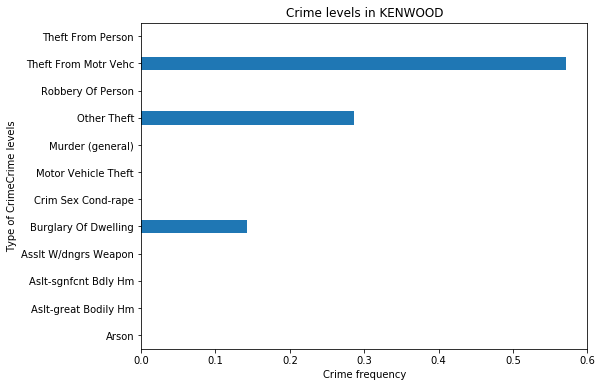

In [250]:
kenwood = crime_grouped.loc['KENWOOD']
kenwood.plot(kind='barh', figsize = (8, 6))
plt.title('Crime levels in KENWOOD')
plt.ylabel('Type of Crime''Crime levels')
plt.xlabel('Crime frequency')
plt.show()

### Venues

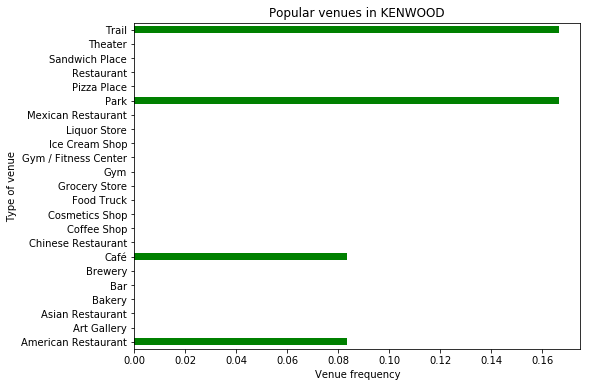

In [271]:
kenwood_venues = mn_venues.loc['KENWOOD']
kenwood_venues.plot(kind='barh', figsize = (8, 6), color='green')
plt.title('Popular venues in KENWOOD')
plt.ylabel('Type of venue')
plt.xlabel('Venue frequency')
plt.show()

### We can see that "theft from motor vehicle" is the most common crime in this neighborhood, and the frequency of other types of crime are pretty low, so Kenwood is a good option. It also appears to be a calm and family-friendly neighborhood, as the most popular venues here are park, trail, and restaurants

### Crime

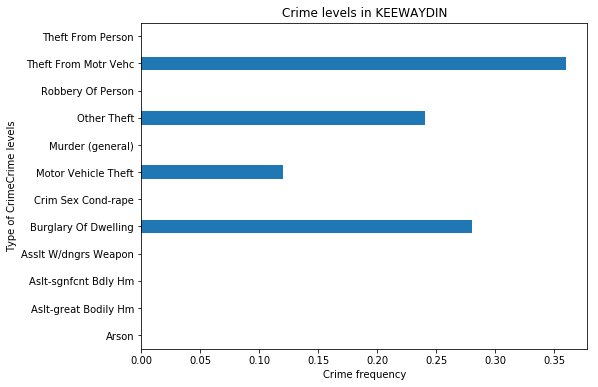

In [251]:
keewaydin = crime_grouped.loc['KEEWAYDIN']
keewaydin.plot(kind='barh', figsize = (8, 6))
plt.title('Crime levels in KEEWAYDIN')
plt.ylabel('Type of Crime''Crime levels')
plt.xlabel('Crime frequency')
plt.show()

### Venues

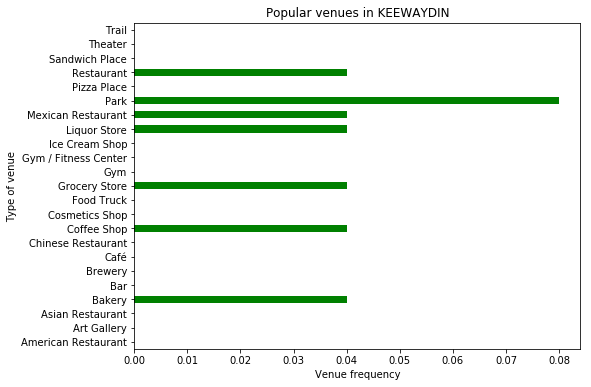

In [272]:
keewaydin_venues = mn_venues.loc['KEEWAYDIN']
keewaydin_venues.plot(kind='barh', figsize = (8, 6), color='green')
plt.title('Popular venues in KEEWAYDIN')
plt.ylabel('Type of venue')
plt.xlabel('Venue frequency')
plt.show()

### Keewaydin is also a good choice, since all popular venues meet our family's requirements and the crime levels are still rather low. However, it has slightly higher rates of 'burglary of dwelling', so it will be up to the family to decide whether they want to consider this neighborhood

### Crime

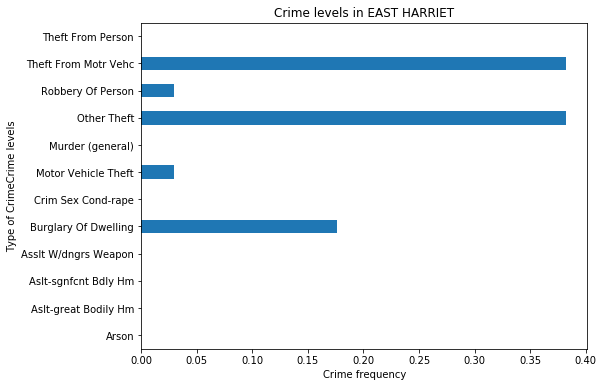

In [252]:
eastHarriet = crime_grouped.loc['EAST HARRIET']
eastHarriet.plot(kind='barh', figsize = (8, 6))
plt.title('Crime levels in EAST HARRIET')
plt.ylabel('Type of Crime''Crime levels')
plt.xlabel('Crime frequency')
plt.show()

### Venues

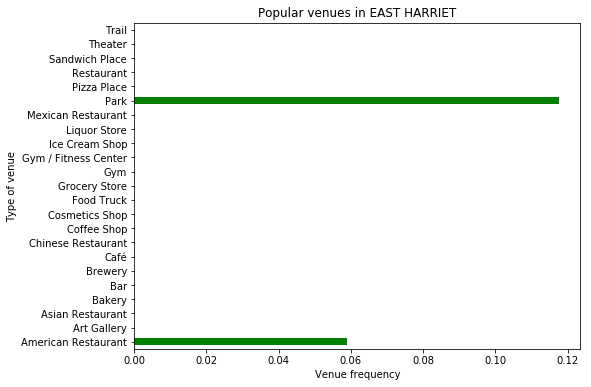

In [273]:
eastHarriet_venues = mn_venues.loc['EAST HARRIET']
eastHarriet_venues.plot(kind='barh', figsize = (8, 6), color='green')
plt.title('Popular venues in EAST HARRIET')
plt.ylabel('Type of venue')
plt.xlabel('Venue frequency')
plt.show()

### Although East Harriet has rather low crime levels, they are still somewhat higher than in the other two neighborhoods, and there are only two relatively popular venues here, so this neighborhood will NOT be recommended

<h3>Cluster 1</h3>

In [111]:
minneapolis_merged.loc[minneapolis_merged['Cluster Labels'] == 1, minneapolis_merged.columns[[0] + list(range(3, minneapolis_merged.shape[1]))]]

Neighborhood  Cluster Labels  1st Most Common Venue  \
13                            WINDOM               1          Garden Center   
15                             FIELD               1            Pizza Place   
16                              PAGE               1              Pet Store   
19   PROSPECT PARK - EAST RIVER ROAD               1            Pizza Place   
20           UNIVERSITY OF MINNESOTA               1            Coffee Shop   
22                         HAWTHORNE               1   Fast Food Restaurant   
27  STEVEN'S SQUARE - LORING HEIGHTS               1            Coffee Shop   
30                            COOPER               1            Coffee Shop   
31                        TANGLETOWN               1           Burger Joint   
35                            FULTON               1     Italian Restaurant   
39                            SEWARD               1                    Bar   
40                        LONGFELLOW               1                    Spa   
41                   LOWRY HILL EAST               1            Coffee Shop   
42                              ECCO               1     Salon / Barbershop   
43                      SOUTH UPTOWN               1         Cosmetics Shop   
44                     EAST PHILLIPS               1     Chinese Restaurant   
50                          NORTHROP               1            Pizza Place   
53                       WINDOM PARK               1            Coffee Shop   
60                      WEST CALHOUN               1                  Beach   
61                       BRYN - MAWR               1                  Trail   
67                          CORCORAN               1     Chinese Restaurant   
70                          ARMATAGE               1            Pizza Place   
72              CEDAR - ISLES - DEAN               1                  Beach   
75                        EAST ISLES               1            Coffee Shop   
85                          WHITTIER               1  Vietnamese Restaurant   
86                           LYNDALE               1         Cosmetics Shop   

     2nd Most Common Venue   3rd Most Common Venue   4th Most Common Venue  \
13  Furniture / Home Store             Video Store                 Brewery   
15                  Bakery      Chinese Restaurant             Coffee Shop   
16                     Gym             Flower Shop          Breakfast Spot   
19                   Hotel      Chinese Restaurant                     Bar   
20             Pizza Place      College Rec Center     Fried Chicken Joint   
22             Pizza Place          Discount Store            Dance Studio   
27                 Theater                    Park              Art Museum   
30            Burger Joint                     Bar                   Trail   
31              Bagel Shop      Chinese Restaurant             Yoga Studio   
35       French Restaurant              Restaurant             Coffee Shop   
39             Pizza Place                    Café             Coffee Shop   
40              Distillery               Bookstore            Burger Joint   
41                Boutique          Breakfast Spot     American Restaurant   
42                   Beach             Coffee Shop       French Restaurant   
43             Pizza Place      Salon / Barbershop           Bowling Alley   
44           Grocery Store  Thrift / Vintage Store      Mexican Restaurant   
50             Coffee Shop             Gas Station          Ice Cream Shop   
53          Sandwich Place                    Park  Furniture / Home Store   
60            Burger Joint             Yoga Studio               Juice Bar   
61             Coffee Shop  Furniture / Home Store                 Brewery   
67             Coffee Shop       Food & Drink Shop       Indian Restaurant   
70                   Trail              Restaurant     Arts & Crafts Store   
72            Burger Joint             Yoga Studio      Chinese Restaurant   
75                

### Based on the most popular venues, we can say that neighborhoods in this cluster are more comfortable for young single adults, so we will NOT make a recommendation from this cluster

<h3>Cluster 2</h3>

In [112]:
minneapolis_merged.loc[minneapolis_merged['Cluster Labels'] == 2, minneapolis_merged.columns[[0] + list(range(3, minneapolis_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue  \
3            VENTURA VILLAGE               2           Coffee Shop   
5              SHINGLE CREEK               2                  Park   
6             LIND - BOHANON               2                  Park   
7            WEBBER - CAMDEN               2                  Park   
9                    VICTORY               2   American Restaurant   
10  HUMBOLDT INDUSTRIAL AREA               2                  Park   
14                  ERICSSON               2                  Park   
21                    JORDAN               2            Restaurant   
23             WILLARD - HAY               2             BBQ Joint   
24              NEAR - NORTH               2                  Park   
25                  HARRISON               2                  Park   
37                  BANCROFT               2                  Park   
38                  STANDISH               2                  Park   
45                 CLEVELAND               2     Food & Drink Shop   
48              AUDUBON PARK               2                  Park   
49                    REGINA               2                  Park   
54              LINDEN HILLS               2                  Park   
56                KING FIELD               2   American Restaurant   
68                    BRYANT               2                  Park   
69                     KENNY               2          Dance Studio   
74                LOWRY HILL               2                  Park   
79                   FOLWELL               2        Sandwich Place   
80                  MCKINLEY               2                  Park   
81         CAMDEN INDUSTRIAL               2                  Park   
83                WAITE PARK               2                  Park   

      2nd Most Common Venue 3rd Most Common Venue    4th Most Common Venue  \
3                      Park         Grocery Store                 Pharmacy   
5               Golf Course         Train Station               Food Truck   
6                 BBQ Joint            Restaurant       Mexican Restaurant   
7            Sandwich Place  Fast Food Restaurant                     Café   
9                      Park          Fishing Spot              Coffee Shop   
10                  Theater         Train Station                      Spa   
14                   Bakery            Playground      Sporting Goods Shop   
21      American Restaurant      Asian Restaurant                   Bakery   
23             Intersection          Liquor Store    Outdoors & Recreation   
24     Fast Food Restaurant        Discount Store       Chinese Restaurant   
25              Coffee Shop               Brewery            Grocery Store   
37        Food & Drink Shop           Coffee Shop                 Pharmacy   
38                      Bar   Sporting Goods Shop              Coffee Shop   
45                 Ski Area             Gift Shop           Sandwich Place   
48                   Bakery              Pharmacy                  Brewery   
49              Pizza Place   American Restaurant       Salon / Barbershop   
54              Snack Place           Coffee Shop                   Bakery   
56                     Park           Coffee Shop  New American Restaurant   
68      American Restaurant           Coffee Shop               Restaurant   
69     Gym / Fitness Center               Brewery            Garden Center   
74  New American Restaurant           Coffee Shop         Sculpture Garden   
79           Discount Store             Gift Shop         Asian Restaurant   
80              Coffee Shop            Print Shop             Intersection   
81               Print Shop         Grocery Store               Food Truck   
83              Pizza Place           Flower Shop                     Café   

     5th Most Common Venue 6th Most Common Venue  \
3                  Theater                  Café   
5        Electronics Store        Baseball Field   
6     Fast

### Neighborhoods in this cluster have no playgrounds, but they do have parks, grocery stores, and many places to eat out. Let's visualize crime rates and popular venues in Harrison, Bryant, Regina, and Bancroft

### Crime

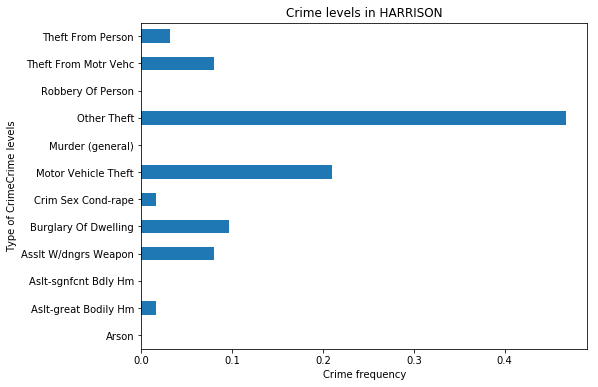

In [253]:
harrison = crime_grouped.loc['HARRISON']
harrison.plot(kind='barh', figsize = (8, 6))
plt.title('Crime levels in HARRISON')
plt.ylabel('Type of Crime''Crime levels')
plt.xlabel('Crime frequency')
plt.show()

### Venues

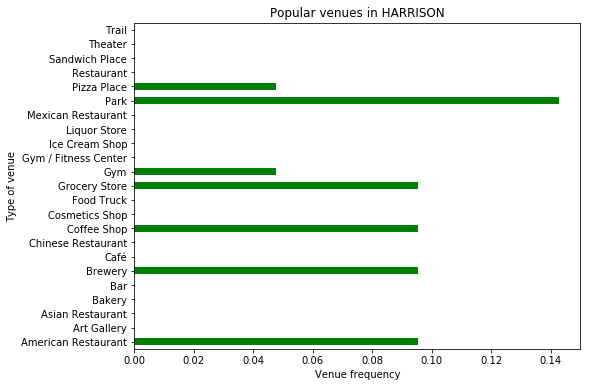

In [274]:
harrison_venues = mn_venues.loc['HARRISON']
harrison_venues.plot(kind='barh', figsize = (8, 6), color='green')
plt.title('Popular venues in HARRISON')
plt.ylabel('Type of venue')
plt.xlabel('Venue frequency')
plt.show()

### With low crime rates and a variety of popular venues that meet the family's requirements, this neighborhood will be one of the best options

### Crime

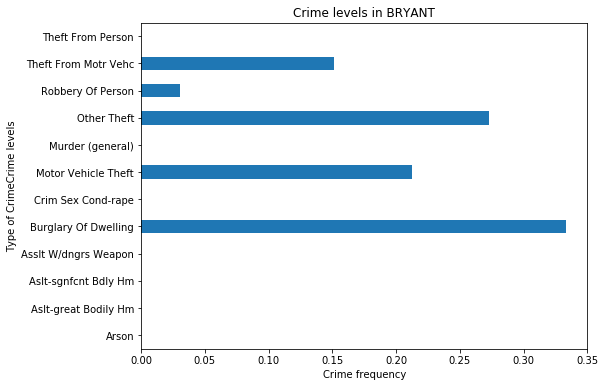

In [254]:
bryant = crime_grouped.loc['BRYANT']
bryant.plot(kind='barh', figsize = (8, 6))
plt.title('Crime levels in BRYANT')
plt.ylabel('Type of Crime''Crime levels')
plt.xlabel('Crime frequency')
plt.show()

### Venues

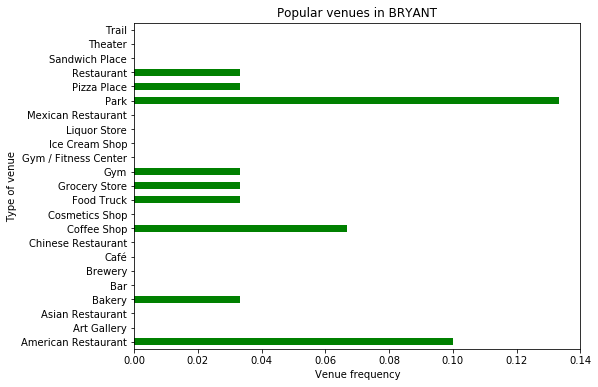

In [275]:
bryant_venues = mn_venues.loc['BRYANT']
bryant_venues.plot(kind='barh', figsize = (8, 6), color='green')
plt.title('Popular venues in BRYANT')
plt.ylabel('Type of venue')
plt.xlabel('Venue frequency')
plt.show()

### Bryant has a good selection of popular venues, but it will NOT be recommended due to its relatively high level of crime

### Crime

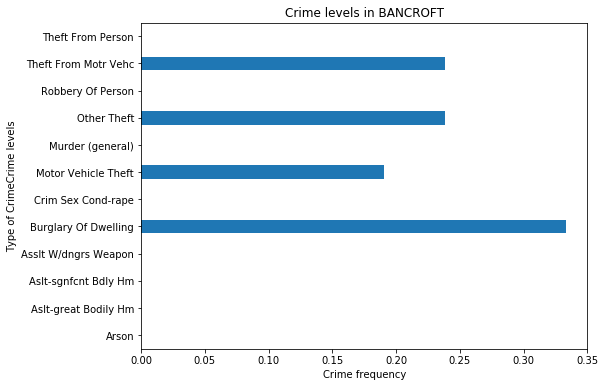

In [255]:
bancroft = crime_grouped.loc['BANCROFT']
bancroft.plot(kind='barh', figsize = (8, 6))
plt.title('Crime levels in BANCROFT')
plt.ylabel('Type of Crime''Crime levels')
plt.xlabel('Crime frequency')
plt.show()

### Venues

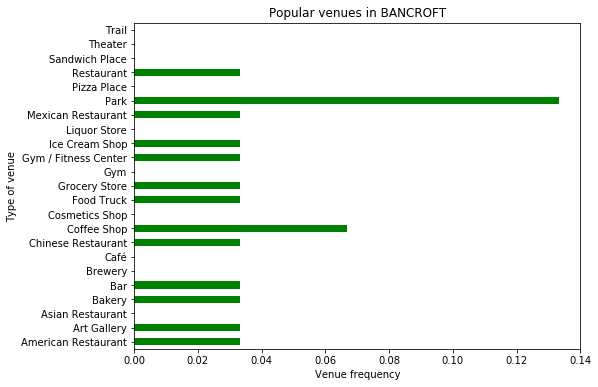

In [276]:
bancroft_venues = mn_venues.loc['BANCROFT']
bancroft_venues.plot(kind='barh', figsize = (8, 6), color='green')
plt.title('Popular venues in BANCROFT')
plt.ylabel('Type of venue')
plt.xlabel('Venue frequency')
plt.show()

### For the same reason as Bryant, Bancroft will NOT be recommened

### Crime 

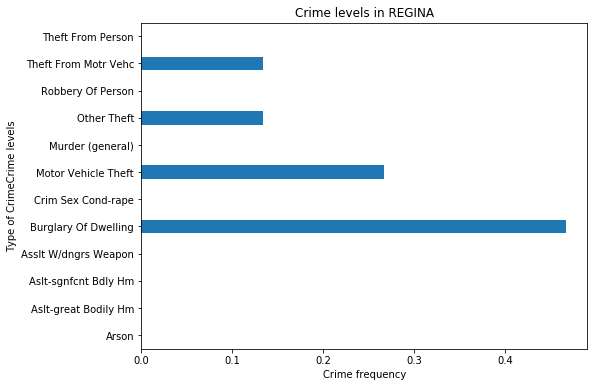

In [256]:
regina = crime_grouped.loc['REGINA']
regina.plot(kind='barh', figsize = (8, 6))
plt.title('Crime levels in REGINA')
plt.ylabel('Type of Crime''Crime levels')
plt.xlabel('Crime frequency')
plt.show()

### Venues

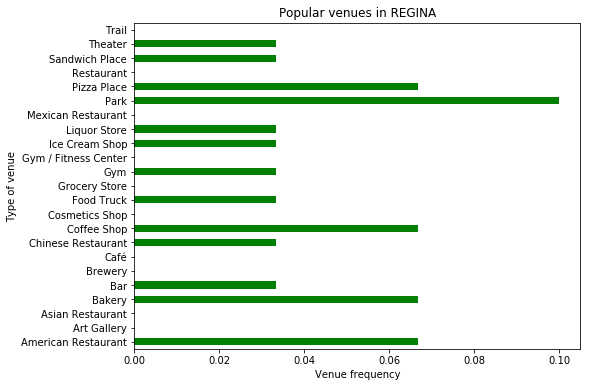

In [277]:
regina_venues = mn_venues.loc['REGINA']
regina_venues.plot(kind='barh', figsize = (8, 6), color='green')
plt.title('Popular venues in REGINA')
plt.ylabel('Type of venue')
plt.xlabel('Venue frequency')
plt.show()

### Again, becuase of its relatively high rates of 'burglary of dwelling', Regina will NOT be recommended

<h3>Cluster 3</h3>

In [113]:
minneapolis_merged.loc[minneapolis_merged['Cluster Labels'] == 3, minneapolis_merged.columns[[0] + list(range(3, minneapolis_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue  \
0      PHILLIPS WEST               3    Mexican Restaurant   
11              HOWE               3          Antique Shop   
47           HOLLAND               3    Mexican Restaurant   
57       MORRIS PARK               3    Mexican Restaurant   
59  MIDTOWN PHILLIPS               3    Mexican Restaurant   
65           CENTRAL               3            Taco Place   
66   POWDERHORN PARK               3    Mexican Restaurant   

    2nd Most Common Venue 3rd Most Common Venue  4th Most Common Venue  \
0   Vietnamese Restaurant   American Restaurant  Performing Arts Venue   
11            Yoga Studio      Asian Restaurant    Indie Movie Theater   
47        Thai Restaurant           Art Gallery                 Bakery   
57                   Café           Pizza Place    Government Building   
59            Coffee Shop            Taco Place                 Bakery   
65          Deli / Bodega         Grocery Store            Art Gallery   
66                 Bakery               Theater    American Restaurant   

   5th Most Common Venue 6th Most Common Venue      7th Most Common Venue  \
0                Theater        Sandwich Place    Scandinavian Restaurant   
11         Grocery Store                  Park               Dance Studio   
47   American Restaurant               Brewery  South American Restaurant   
57      Asian Restaurant  Fast Food Restaurant                  Gift Shop   
59         Grocery Store               Theater                    Brewery   
65           Bus Station             Gastropub     Furniture / Home Store   
66  Caribbean Restaurant           Coffee Shop                 Taco Place   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0                    Bar            Taco Place  College Arts Building  
11          Cycle Studio            Playground                    Pub  
47          Liquor Store    Salon / Barbershop                   Café  
57            Playground        Breakfast Spot                    Spa  
59        Breakfast Spot   Fried Chicken Joint              Bookstore  
65          Liquor Store    Mexican Restaurant     Miscellaneous Shop  
66          Burger Joint            Food Court     Miscellaneous Shop

### Neighborhoods in this cluster have many restaurants, but there are few grocery shops and places for leisure (e.g. parks), so we will NOT recommend any of them

<h3>Cluster 4</h3>

In [114]:
minneapolis_merged.loc[minneapolis_merged['Cluster Labels'] == 4, minneapolis_merged.columns[[0] + list(range(3, minneapolis_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue  \
1                 DOWNTOWN WEST               4               Theater   
2                 DOWNTOWN EAST               4                   Bar   
4             SUMNER - GLENWOOD               4               Brewery   
8                     BOTTINEAU               4              Dive Bar   
17                         COMO               4                  Café   
18              CEDAR RIVERSIDE               4               Theater   
26                  LORING PARK               4   American Restaurant   
32                   NORTH LOOP               4               Brewery   
51                     SHERIDAN               4           Art Gallery   
52                   LOGAN PARK               4           Art Gallery   
58        MID - CITY INDUSTRIAL               4  Fast Food Restaurant   
62               NORTHEAST PARK               4           Coffee Shop   
63             ST. ANTHONY WEST               4           Pizza Place   
64             ST. ANTHONY EAST               4               Brewery   
71                     BELTRAMI               4               Brewery   
76                  ELLIOT PARK               4                 Hotel   
77  NICOLLET ISLAND - EAST BANK               4             Pet Store   
78                 MARCY HOLMES               4             Pet Store   

      2nd Most Common Venue    3rd Most Common Venue  \
1        Italian Restaurant  New American Restaurant   
2                     Hotel                     Park   
4    Thrift / Vintage Store           Farmers Market   
8               Coffee Shop         Theme Restaurant   
17               Food Truck              Coffee Shop   
18                      Bar                     Park   
26  New American Restaurant         Sculpture Garden   
32         Baseball Stadium              Coffee Shop   
51               Steakhouse                 Dive Bar   
52                  Brewery                      Gym   
58                     Café               Food Truck   
62              Art Gallery                     Park   
63                     Park                  Brewery   
64                 Dive Bar              Yoga Studio   
71                BBQ Joint                 Dive Bar   
76           Breakfast Spot                  Brewery   
77            Movie Theater             Liquor Store   
78                     Café           Cosmetics Shop   

        4th Most Common Venue 5th Most Common Venue   6th Most Common Venue  \
1                 Music Venue      Baseball Stadium              Restaurant   
2         Japanese Restaurant           Yoga Studio          Scenic Lookout   
4                  Food Truck         Deli / Bodega        Business Service   
8              Ice Cream Shop   American Restaurant                    Café   
17  Middle Eastern Restaurant                   Bar          Baseball Field   
18             Scenic Lookout               Brewery            Liquor Store   
26         Salon / Barbershop               Gay Bar      Italian Restaurant   
32        American Restaurant           Comedy Club              Food Truck   
51                Pizza Place   American Restaurant      Salon / Barbershop   
52         Mexican Restaurant           Yoga Studio              Distillery   
58                  Gastropub                  Park             Art Gallery   
62             Sandwich Place         Big Box Store  Furniture / Home Store   
63              Bowling Alley          Climbing Gym             Comedy Club   
64               Liquor Store            Taco Place        Sushi Restaurant   
71                Coffee Shop           Yoga Studio                    Park   
76                Coffee Shop                  Park              Steakhouse   
77        Sporting Goods Shop          Cocktail Bar              Restaurant   
78           Sushi Restaurant   Sporting Goods Shop          Breakfast Spot   

      7th Most Common Venue 8th Most Common Venue   9th Most Com

### From this cluster, St.Anthony West and Beltrami are the most preferable neighborhoods

### Crime

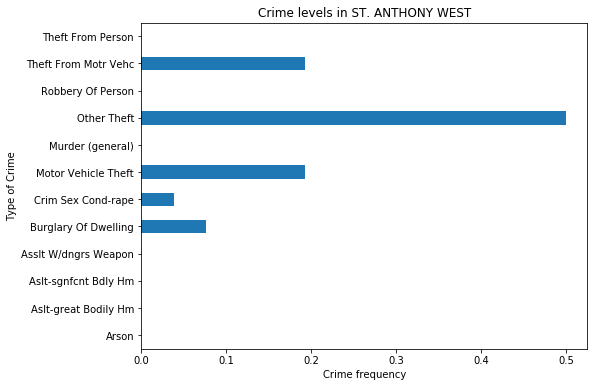

In [266]:
stAntonyWest = crime_grouped.loc['ST. ANTHONY WEST'] 
stAntonyWest.plot(kind='barh', figsize = (8, 6))
plt.title('Crime levels in ST. ANTHONY WEST')
plt.ylabel('Type of Crime')
plt.xlabel('Crime frequency')
plt.show()

### Venues

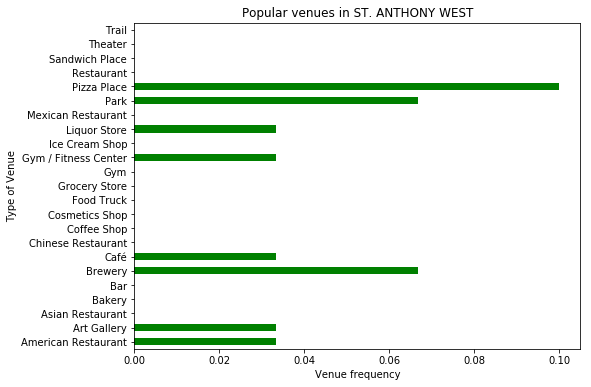

In [278]:
stAntonyWest_venues = mn_venues.loc['ST. ANTHONY WEST'] 
stAntonyWest_venues.plot(kind='barh', figsize = (8, 6), color='green')
plt.title('Popular venues in ST. ANTHONY WEST')
plt.ylabel('Type of Venue')
plt.xlabel('Venue frequency')
plt.show()

### The neighborhood has rather high levels of 'other theft', but other types of crime are much less frequent, and the selection of popular venues is quite close to the family's requirements, so this neighborhood will be recommended

### Crime

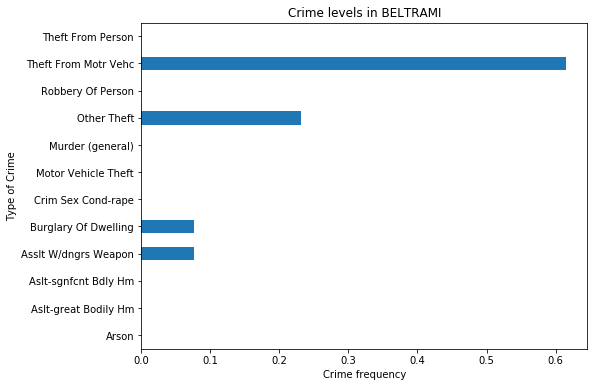

In [267]:
beltrami = crime_grouped.loc['BELTRAMI']
beltrami.plot(kind='barh', figsize = (8, 6))
plt.title('Crime levels in BELTRAMI')
plt.ylabel('Type of Crime')
plt.xlabel('Crime frequency')
plt.show()

### Venues

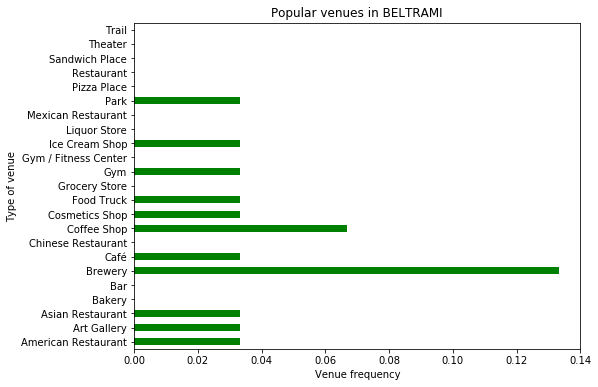

In [279]:
beltrami_venues = mn_venues.loc['BELTRAMI']
beltrami_venues.plot(kind='barh', figsize = (8, 6), color='green')
plt.title('Popular venues in BELTRAMI')
plt.ylabel('Type of venue')
plt.xlabel('Venue frequency')
plt.show()

### Although Beltrami has high rates of 'theft from motor vehicle', other types of crime have small frequency; the neighborhood also has a good selection of popular venues. So, it will be suggested as an option

<h3> Cluster 5 </h3>

In [115]:
minneapolis_merged.loc[minneapolis_merged['Cluster Labels'] == 5, minneapolis_merged.columns[[0] + list(range(3, minneapolis_merged.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Venue  \
82     COLUMBIA PARK               5           Golf Course   
84  MARSHALL TERRACE               5               Brewery   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
82               Brewery                   Gym                  Park   
84        Cosmetics Shop         Train Station                   Bar   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
82       Motorcycle Shop               Dog Run           Rugby Pitch   
84        Baseball Field      Theme Restaurant           Music Store   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
82           Yoga Studio        Cosmetics Shop            Pizza Place  
84          Liquor Store                   Gym        Warehouse Store

### Neither of the two neighborhoods is suitable for our family

# Results and Discussion

Cluster analysis showed that two (2) out of six (6) formed clusters did not meet the requirements of the stakeholders, so neighborhoods from those clusters were not considered. 

Out of other four (4) clusters, a total of five (5) neighborhoods were chosen as suitable options for the stakeholders. 

The first cluster (cluster 0) includes relatively quiet neighborhoods with access to green zones. Two neighborhoods (<b>Kenwood and Keewaydin</b>) were identified as suitable options. These neighborhoods are generally more family-friendly and have low crime rates. However, they are both farther from Downtown East, which is the neighborhood where one of the parents in the family plans to work. So, the stakeholders will need to consider whether the commute time is acceptable.

The third cluster (cluster 2) also has neighborhoods that are close to parks and have a good selection of restaurants/shops. However, most neighborhoods in this cluster also have relatively high crime rates (because they are closer to downtown), so only one neighborhood was recommended - <b>Harrison</b>.

In the fifth cluster (cluster 4), two neighborhoods were identified as suitable (both have access to a park, in addition to various options to eat out); both have sufficiently low crime rates, so both were recommened - <b>St.Anthony West and Beltrami</b>.

# Conclusion

Purpose of this project was to identify neighborhoods in Minneapolis that the stakeholder family could relocate to. Using data from Foursquare API we identified the most common venue categories in each neighborhood and were able to cluster Minneapolist neighborhoods using that information. Each cluster was analyzed to identify neighborhoods that suited the family's preferences (if such neighborhoods were present in the cluster). The chosen neighborhoods were compared using data on crime levels and the most popular venues.

The final decission on optimal neighborhood will be made by the stakeholders (i.e. the family) based on specific characteristics of the recommended neighborhoods .